In [1]:
import pychemelt as pychem
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots

from pychemelt.utils.math import (
    linear_baseline,
    exponential_baseline
)

from pychemelt.utils.plotting import PlotConfig, AxisConfig

from scripts import (
    display_figure_static, 
    aux_create_pychem_sim,
    fit_pychem_sim,
    DG_at_T,
    folded_fraction
    )

In [3]:
RNG_SEED = 2

DEF_PARAMS = {

     # Thermodynamic parameters

    'DHm': np.nan, # Enthalpy of unfolding
    'Tm': np.nan, # Temperature of unfolding
    'Cp0': np.nan, # Heat capacity of unfolding
    'm0': np.nan, # m-value of unfolding
    'm1': 0, # m-dependence on temperature, not modelled

    # Native baseline parameters

    'p1_N': 2.5,  # dependence on denaturant concentration
    'p2_N': 24,   # intercept
    'p3_N': -0.27,  # slope term
    'p4_N': 0, # ignored

    # Unfolded baseline parameters

    'p1_U': 1.6, # dependence on denaturant concentration
    'p2_U': -4, # intercept
    'p3_U': 80.5, # pre-exponential factor
    'p4_U': 0.0224, # exponential coefficient

    # Baseline functions

    'baseline_N_fx':linear_baseline,
    'baseline_U_fx':exponential_baseline
}

In [4]:
# Now we create a combination of DH, CP, and m0 values.

Tm = 120

Cp = [1,2]
DH = [100,200]
m0 = [2,4,6]

combinations = []

for cp in Cp:
    for dh in DH:
        for m in m0:
            combinations.append((cp, dh, m))

df_mesh = pd.DataFrame(combinations, columns=['Cp','DH','m0'])

df_mesh['Tm'] = Tm

df_mesh['DG_10C'] = DG_at_T(
    10,
    Tm,
    Cp0=df_mesh['Cp'].values,
    DHm=df_mesh['DH'].values
)

df_mesh['fN_10C'] = folded_fraction(df_mesh['DG_10C'].values, 10)

# Filter combinations that give fN_10C higher than 0.99
df_mesh = df_mesh[df_mesh['fN_10C'] > 0.99]

len(df_mesh)

9

In [5]:
pychem_sims_lst = []

for row in df_mesh.itertuples():
    params = DEF_PARAMS.copy()
    params['Tm'] = row.Tm
    params['Cp0'] = row.Cp
    params['DHm'] = row.DH
    params['m0'] = row.m0

    print(f"Generating simulation with Cp={row.Cp}, DH={row.DH}, m0={row.m0}")

    pychem_sim = aux_create_pychem_sim(params,rng_seed=RNG_SEED)

    try:

        fit_pychem_sim(pychem_sim,n_residues=150)

    except:

        pass

    pychem_sims_lst.append(pychem_sim)

Generating simulation with Cp=1, DH=100, m0=2
Generating simulation with Cp=1, DH=100, m0=4
Generating simulation with Cp=1, DH=100, m0=4
Generating simulation with Cp=1, DH=100, m0=6
Generating simulation with Cp=1, DH=100, m0=6
Generating simulation with Cp=1, DH=200, m0=2
Generating simulation with Cp=1, DH=200, m0=2
Generating simulation with Cp=1, DH=200, m0=4
Generating simulation with Cp=1, DH=200, m0=4
Generating simulation with Cp=1, DH=200, m0=6
Generating simulation with Cp=1, DH=200, m0=6
Generating simulation with Cp=2, DH=200, m0=2
Generating simulation with Cp=2, DH=200, m0=2
Generating simulation with Cp=2, DH=200, m0=4
Generating simulation with Cp=2, DH=200, m0=4


/Users/oburastero/Desktop/arise/pychemelt_analyses/.venv/lib/python3.12/site-packages/pychemelt/utils/math.py:119: RuntimeWarning: overflow encountered in exp
  return a + c * np.exp(-alpha * dt) + den_slope * d
/Users/oburastero/Desktop/arise/pychemelt_analyses/.venv/lib/python3.12/site-packages/pychemelt/utils/signals.py:71: RuntimeWarning: invalid value encountered in multiply
  return  fn*(S_native) + fu*(S_unfolded)
/Users/oburastero/Desktop/arise/pychemelt_analyses/.venv/lib/python3.12/site-packages/pychemelt/utils/signals.py:71: RuntimeWarning: invalid value encountered in multiply
  return  fn*(S_native) + fu*(S_unfolded)


Generating simulation with Cp=2, DH=200, m0=6


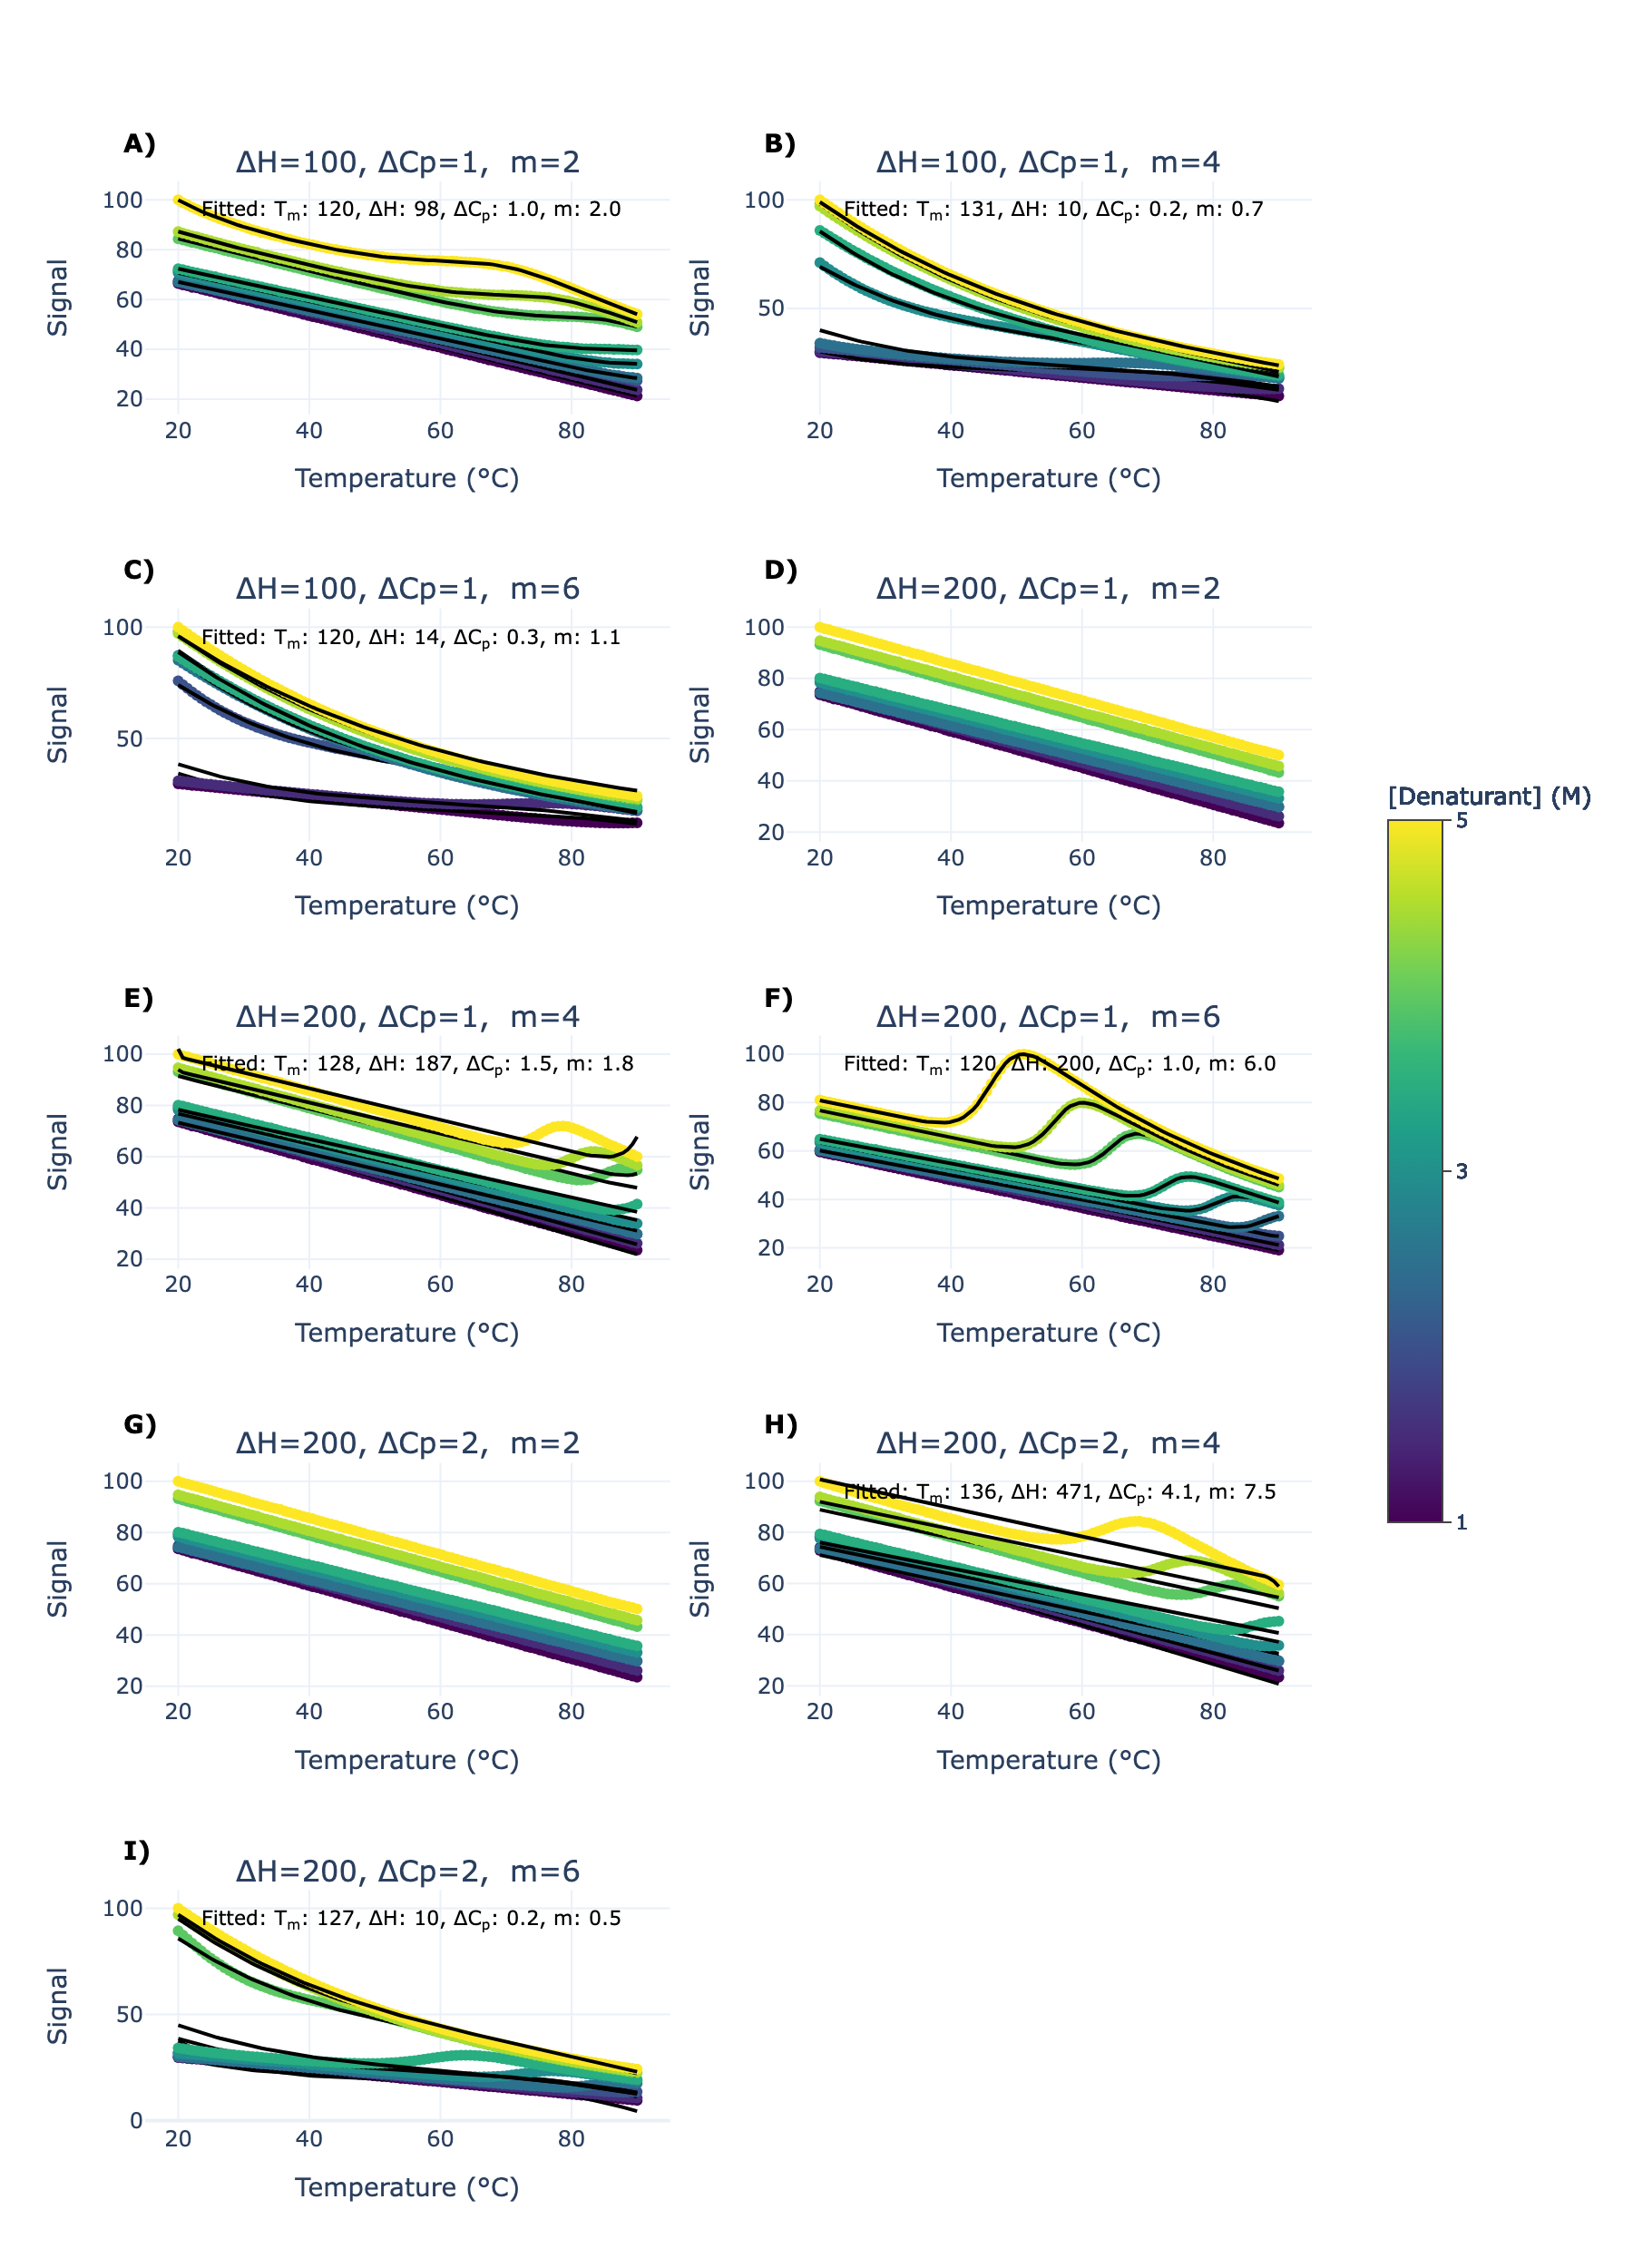

In [10]:
n_plots = len(df_mesh)
n_cols = 2
n_rows = int(np.ceil(n_plots / n_cols))

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    subplot_titles=[
        f"ΔH={row.DH}, ΔCp={row.Cp},  m={row.m0}"
        for row in df_mesh.itertuples()
    ]
)

plot_config = PlotConfig()
plot_config.line_width = 2
plot_config.marker_size = 6
plot_config.font_size = 12


for i,row in enumerate(df_mesh.itertuples()):

    # Validate index

    if i >= len(pychem_sims_lst):
        break


    pychem_sim = pychem_sims_lst[i]

    # create the plotly figure for this simulation (temporary)

    tmp_fig = pychem.plot_unfolding(
        pychem_sim,
        plot_config=plot_config
        )

    row = i // n_cols + 1
    col = i % n_cols + 1

    # Copy all traces into the subplot (once)
    for trace in tmp_fig.data:
        fig.add_trace(trace, row=row, col=col)

    # Add an annotation inside the subplot showing the fitted Tm
    axis_index = i + 1
    # Plotly expects 'x domain'/'y domain' (no '1') for the first axis; for others use 'xN domain'
    if axis_index == 1:
        xref = 'x domain'
        yref = 'y domain'
    else:
        xref = f'x{axis_index} domain'
        yref = f'y{axis_index} domain'

    # Add panel label (A, B, C, etc.)
    panel_label = chr(65 + i)  # 65 is ASCII code for 'A'
    fig.add_annotation(
        x=-0.05,
        y=1.25,
        xref=xref,
        yref=yref,
        text=f'<b>{panel_label})</b>',
        showarrow=False,
        align='left',
        font=dict(size=14, color='black')
    )

    # Verify if attribute params_df exists
    if hasattr(pychem_sim,'params_df'):

        params = pychem_sim.params_df
        fitted_Tm = params.iloc[0, 1]
        fitted_dh = params.iloc[1, 1]
        fitted_cp = params.iloc[2, 1]
        fitted_m0 = params.iloc[3, 1]

        fig.add_annotation(
            x=0.1,
            y=0.95,
            xref=xref,
            yref=yref,
            text=f'Fitted: T<sub>m</sub>: {fitted_Tm:.0f}, '
            f'ΔH: {fitted_dh:.0f}, ΔC<sub>p</sub>: {fitted_cp:.1f}, m: {fitted_m0:.1f}',
            showarrow=False,
            align='left',
            font=dict(size=11, color='black')
        )

# Optional layout tweaks
fig.update_layout(
    height=250 * n_rows,
    width=900,
    showlegend=False
)

fig.update_layout(
    template="plotly_white",
    paper_bgcolor="white",
    plot_bgcolor="white"
)

fig.update_xaxes(title_text="Temperature (°C)")
fig.update_yaxes(title_text="Signal")

fig.write_image("4_evaluate_all_params_fitting.png", scale=2)
display_figure_static(fig,height=250 * n_rows, width=900)